# **Identifying the causes and contributing factors of road collisions with injuries and fatalities in the City of Seattle, USA**

## Rob Highett-Smith
### 8 September 2020

# Contents
1. Imports
2. Data acquisition, variable selection & cleaning / processing <br>
2.1 Data source <br>
2.2 Variable selection <br>
2.3 Data cleaning & processing <br>
&nbsp;&nbsp;2.3.1 Data Review <br>
&nbsp;&nbsp;2.3.2 Data formatting <br>
&nbsp;&nbsp;2.3.3 Missing Data <br>
&nbsp;&nbsp;2.3.4 Data Types <br>
&nbsp;&nbsp;2.3.5 Check all Data cleaning & processing changes <br>
3. Exploratory Data Analysis <br>
3.1 Variable Distributions <br>
&nbsp;&nbsp;3.1.1 Bar charts of frequency distribution for all Variables <br>
&nbsp;&nbsp;3.1.2 Bar charts comparing frequency distribution of all Variables with Dependent Variable <br>
3.2 Create Dummy Variables <br>
3.3 Pairwise Variable Comparison Matrix <br>
4. Modelling <br>
4.1 Define Features <br>
4.2 Develop Test & Train sets <br>
4.3 Balance Dataset <br>
&nbsp;&nbsp;4.3.1 Oversample minority class <br>
&nbsp;&nbsp;4.3.2 Undersample majority class <br>
&nbsp;&nbsp;4.3.3 Generate synthetic sample using SMOTE <br>
4.4 Model development <br>
&nbsp;&nbsp;4.4.1 KNN <br>
&nbsp;&nbsp;4.4.2 SVM <br>
&nbsp;&nbsp;4.4.3 Decision Tree <br>
&nbsp;&nbsp;4.4.4 Logistic Regression <br>
5. Results

# 1. Imports

In [1]:
import pandas as pd
import sidetable
import numpy as np
import seaborn as sns
import itertools
import pydotplus
import math
from scipy import stats
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import svm
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, f1_score, jaccard_score, log_loss
from sklearn.metrics.pairwise import pairwise_distances
from scipy.spatial.distance import pdist
from io import StringIO
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.image as mpimg
from matplotlib.patches import Patch
%matplotlib inline

# **2.	Data acquisition, variable selection & cleaning / processing**

## **2.1 Data source**
The data for this project was obtained from the [City of Seattle Open Data portal](https://data.seattle.gov/Land-Base/Collisions/9kas-rb8d).

Data was downloaded on the 6 September and includes 221,266 records relating the road collisions between 2004 and present updated on 5 September 2020).

In [2]:
df = pd.read_csv('Collisions.csv')

In [3]:
df.shape

(221266, 40)

## **2.2 Variable selection**

### **2.2.1 Dependent (Target) variable**

In [4]:
df['SEVERITYCODE'].value_counts()

1     137485
2      58698
0      21635
2b      3098
3        349
Name: SEVERITYCODE, dtype: int64

In [5]:
# Consolidate and convert 'SEVERITYCODE', so 0 = prop damage, 1= injury / fatality and drop unknowns
cleanupDV_dict = {'SEVERITYCODE':     {'0': np.nan, '1': 0, '2': 1, "2b": 1, '3': 1}}
df.replace(cleanupDV_dict, inplace=True)
df.dropna(axis = 0, subset = ['SEVERITYCODE'], inplace=True)
df['SEVERITYCODE'] = df['SEVERITYCODE'].astype('int64')
print(df.shape)
df['SEVERITYCODE'].value_counts()

(199630, 40)


0    137485
1     62145
Name: SEVERITYCODE, dtype: int64

### **2.2.2 Independent variable selection**

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199630 entries, 0 to 221265
Data columns (total 40 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   X                194228 non-null  float64
 1   Y                194228 non-null  float64
 2   OBJECTID         199630 non-null  int64  
 3   INCKEY           199630 non-null  int64  
 4   COLDETKEY        199630 non-null  int64  
 5   REPORTNO         199630 non-null  object 
 6   STATUS           199630 non-null  object 
 7   ADDRTYPE         197699 non-null  object 
 8   INTKEY           67338 non-null   float64
 9   LOCATION         196938 non-null  object 
 10  EXCEPTRSNCODE    88001 non-null   object 
 11  EXCEPTRSNDESC    5681 non-null    object 
 12  SEVERITYCODE     199630 non-null  int64  
 13  SEVERITYDESC     199630 non-null  object 
 14  COLLISIONTYPE    194765 non-null  object 
 15  PERSONCOUNT      199630 non-null  int64  
 16  PEDCOUNT         199630 non-null  int6

In [7]:
for col in df:
    print(col)
    print(df[col].nunique())
    print(df[col].unique())

X
24016
[1256925.33302788 1268898.14558415 1260615.23491967 ... 1265454.00094062
 1286880.09728256 1272533.10315587]
Y
24014
[209863.66273096 254213.51544838 247712.95678571 ... 238340.65296811
 195438.35436419 243705.67492561]
OBJECTID
199630
[     1      2      3 ... 221264 221265 221266]
INCKEY
199630
[326234 326246 329254 ... 318948 319956 320317]
COLDETKEY
199630
[327734 327746 330754 ... 320448 321456 321817]
REPORTNO
199627
['E984735' 'E985430' 'EA16720' ... 'E920056' '3795268' '3810590']
STATUS
2
['Matched' 'Unmatched']
ADDRTYPE
3
['Intersection' 'Block' nan 'Alley']
INTKEY
7689
[31893. 24228.    nan ... 31292. 30594. 28074.]
LOCATION
24234
['CALIFORNIA AVE SW AND SW GENESEE ST' 'STONE AVE N AND N 80TH ST'
 'NW MARKET ST BETWEEN 14TH AVE NW AND 15TH AVE NW' ...
 'RAYE ST AND WARREN AVE N'
 'S CLOVERDALE ST BETWEEN SEWARD PARK AVE S AND 55TH AVE S'
 'THACKERAY PL NE BETWEEN NE 42ND ST AND NE 43RD ST']
EXCEPTRSNCODE
2
[' ' nan 'NEI']
EXCEPTRSNDESC
1
[nan 'Not Enough Information, 

In [8]:
df.stb.missing()

,missing,total,percent
PEDROWNOTGRNT,194443,199630,97.401693
EXCEPTRSNDESC,193949,199630,97.154235
SPEEDING,189718,199630,95.034814
INATTENTIONIND,169442,199630,84.878024
INTKEY,132292,199630,66.268597
EXCEPTRSNCODE,111629,199630,55.917948
SDOTCOLNUM,82630,199630,41.391574
JUNCTIONTYPE,6375,199630,3.193408
Y,5402,199630,2.706006
X,5402,199630,2.706006


## **2.3 Data cleaning & processing**

### **2.3.1 Data Review**

In [9]:
#create new df for modelling
modeldf = df[['SEVERITYCODE','ADDRTYPE','INCDATE','INATTENTIONIND','UNDERINFL','WEATHER','ROADCOND','LIGHTCOND','PEDROWNOTGRNT','SPEEDING']]

In [10]:
modeldf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199630 entries, 0 to 221265
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   SEVERITYCODE    199630 non-null  int64 
 1   ADDRTYPE        197699 non-null  object
 2   INCDATE         199630 non-null  object
 3   INATTENTIONIND  30188 non-null   object
 4   UNDERINFL       194785 non-null  object
 5   WEATHER         194575 non-null  object
 6   ROADCOND        194655 non-null  object
 7   LIGHTCOND       194487 non-null  object
 8   PEDROWNOTGRNT   5187 non-null    object
 9   SPEEDING        9912 non-null    object
dtypes: int64(1), object(9)
memory usage: 16.8+ MB


In [11]:
for col in modeldf:
    print('\033[1m' + col + '\033[0m')
    print("# of values: ",modeldf[col].nunique())
    print("Values: ",modeldf[col].unique())
    print(modeldf[col].value_counts())

SEVERITYCODE
# of values:  2
Values:  [1 0]
0    137485
1     62145
Name: SEVERITYCODE, dtype: int64
ADDRTYPE
# of values:  3
Values:  ['Intersection' 'Block' nan 'Alley']
Block           129600
Intersection     67338
Alley              761
Name: ADDRTYPE, dtype: int64
INCDATE
# of values:  6078
Values:  ['2019/11/20 00:00:00+00' '2019/11/18 00:00:00+00'
 '2020/02/20 00:00:00+00' ... '2019/04/17 00:00:00+00'
 '2019/06/04 00:00:00+00' '2019/04/14 00:00:00+00']
2006/11/02 00:00:00+00    100
2008/10/03 00:00:00+00     93
2005/05/18 00:00:00+00     87
2006/01/13 00:00:00+00     85
2005/11/05 00:00:00+00     84
                         ... 
2020/08/15 00:00:00+00      2
2020/08/27 00:00:00+00      1
2015/12/25 00:00:00+00      1
2020/08/25 00:00:00+00      1
2020/08/19 00:00:00+00      1
Name: INCDATE, Length: 6078, dtype: int64
INATTENTIONIND
# of values:  1
Values:  [nan 'Y']
Y    30188
Name: INATTENTIONIND, dtype: int64
UNDERINFL
# of values:  4
Values:  ['N' '0' 'Y' '1' nan]
N    103480

In [12]:
modeldf.stb.missing()

,missing,total,percent
PEDROWNOTGRNT,194443,199630,97.401693
SPEEDING,189718,199630,95.034814
INATTENTIONIND,169442,199630,84.878024
LIGHTCOND,5143,199630,2.576266
WEATHER,5055,199630,2.532185
ROADCOND,4975,199630,2.492110
UNDERINFL,4845,199630,2.426990
ADDRTYPE,1931,199630,0.967289
SEVERITYCODE,0,199630,0.000000
INCDATE,0,199630,0.000000


### **2.3.2 Data formatting**

In [13]:
# recode INATTENTIONIND to a binary variable O=No, 1=Yes
cleanupINAT_dict = {'INATTENTIONIND':     {np.nan: 0, 'Y': 1}}
modeldf.replace(cleanupINAT_dict, inplace=True)
modeldf['INATTENTIONIND'].value_counts()

#tried these alternatives - still had same 'SettingWithCopyWarning' issue (SO STICK WITH ABOVE)
#modeldf.loc[:, ['INATTENTIONIND','PEDROWNOTGRNT','SPEEDING']].fillna(0, inplace = True)
#modeldf.loc[:,'PEDROWNOTGRNT'].replace(np.nan,0, inplace = True)

C:\Users\rphig\anaconda3\lib\site-packages\pandas\core\generic.py:6662: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res[c] = res[c].replace(


0    169442
1     30188
Name: INATTENTIONIND, dtype: int64

In [14]:
# recode SPEEDING to a binary variable O=No, 1=Yes
cleanupSPEED_dict = {'SPEEDING':     {np.nan: 0, 'Y': 1}}
modeldf.replace(cleanupSPEED_dict, inplace=True)
modeldf['SPEEDING'].value_counts()

0    189718
1      9912
Name: SPEEDING, dtype: int64

In [15]:
# recode PEDROWNOTGRNT to a binary variable O=No, 1=Yes
cleanupPED_dict = {'PEDROWNOTGRNT':     {np.nan: 0, 'Y': 1}}
modeldf.replace(cleanupPED_dict, inplace=True)
modeldf['PEDROWNOTGRNT'].value_counts()

0    194443
1      5187
Name: PEDROWNOTGRNT, dtype: int64

In [16]:
# clean up UNDERINFL
cleanupUNDER_dict = {'UNDERINFL':     {'N': 0,'0': 0,'Y': 1,'1': 1}}
modeldf.replace(cleanupUNDER_dict, inplace=True)
modeldf['UNDERINFL'].value_counts()

0.0    185156
1.0      9629
Name: UNDERINFL, dtype: int64

In [17]:
# recode smaller values in WEATHER to reduce unique values
recodeWEATHER_dict = {'WEATHER':     {'Unknown':np.nan,'Fog/Smog/Smoke':'Other','Sleet/Hail/Freezing Rain':'Raining','Blowing Sand/Dirt':'Other','Severe Crosswind':'Other','Blowing Snow':'Snowing','Partly Cloudy': 'Overcast'}}
modeldf.replace(recodeWEATHER_dict, inplace=True)
modeldf['WEATHER'].value_counts()

Clear       114360
Raining      34136
Overcast     28516
Other         1512
Snowing        920
Name: WEATHER, dtype: int64

In [18]:
# recode smaller values in ROADCOND to reduce unique values
recodeROAD_dict = {'ROADCOND':     {'Unknown':np.nan,'Standing Water':'Wet','Ice':"Wet",'Snow/Slush':'Wet','Sand/Mud/Dirt':"Other",'Oil':'Wet'}}
modeldf.replace(recodeROAD_dict, inplace=True)
modeldf['ROADCOND'].value_counts()

Dry      128171
Wet       51140
Other       213
Name: ROADCOND, dtype: int64

In [19]:
# recode smaller values in LIGHTCOND to Daylight / Night to reduce unique values
recodeLIGHT_dict = {'LIGHTCOND':     {'Dark - Street Lights On':'Night','Dusk':'Night','Unknown':np.nan,'Dark - Street Lights Off':'Night','Dark - Unknown Lighting':'Night','Other':np.nan,'Dark - No Street Lights':'Night','Dawn':'Daylight'}}
modeldf.replace(recodeLIGHT_dict, inplace=True)
modeldf['LIGHTCOND'].value_counts()

Daylight    121762
Night        58958
Name: LIGHTCOND, dtype: int64

In [20]:
# create Weekday / Weekend variable from INCDATE (Weekday = 0, Weekend=1)
modeldf['INCDATE'] = pd.to_datetime(modeldf['INCDATE'])
modeldf['dayofweek'] = modeldf['INCDATE'].dt.dayofweek
modeldf['Weekend'] = modeldf['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
modeldf.drop(['INCDATE'], axis=1, inplace=True)
modeldf.drop(['dayofweek'], axis=1, inplace=True)

<ipython-input-20-aad66c653137>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  modeldf['INCDATE'] = pd.to_datetime(modeldf['INCDATE'])
<ipython-input-20-aad66c653137>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  modeldf['dayofweek'] = modeldf['INCDATE'].dt.dayofweek
<ipython-input-20-aad66c653137>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

### **2.3.3 Missing Data**

In [21]:
modeldf.stb.missing()

,missing,total,percent
WEATHER,20186,199630,10.111707
ROADCOND,20106,199630,10.071633
LIGHTCOND,18910,199630,9.472524
UNDERINFL,4845,199630,2.426990
ADDRTYPE,1931,199630,0.967289
SEVERITYCODE,0,199630,0.000000
INATTENTIONIND,0,199630,0.000000
PEDROWNOTGRNT,0,199630,0.000000
SPEEDING,0,199630,0.000000
Weekend,0,199630,0.000000


In [22]:
modeldf.dropna(axis = 0,inplace = True)

<ipython-input-22-c16710fecfed>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  modeldf.dropna(axis = 0,inplace = True)


### **2.3.4 Data Types**

In [23]:
modeldf.dtypes

SEVERITYCODE        int64
ADDRTYPE           object
INATTENTIONIND      int64
UNDERINFL         float64
WEATHER            object
ROADCOND           object
LIGHTCOND          object
PEDROWNOTGRNT       int64
SPEEDING            int64
Weekend             int64
dtype: object

In [24]:
modeldf['UNDERINFL'] = modeldf['UNDERINFL'].astype('int64')

<ipython-input-24-628cfc020bd8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  modeldf['UNDERINFL'] = modeldf['UNDERINFL'].astype('int64')


In [25]:
modeldf.dtypes

SEVERITYCODE       int64
ADDRTYPE          object
INATTENTIONIND     int64
UNDERINFL          int64
WEATHER           object
ROADCOND          object
LIGHTCOND         object
PEDROWNOTGRNT      int64
SPEEDING           int64
Weekend            int64
dtype: object

### **2.3.5 Check all Data cleaning & processing changes**

In [26]:
for col in modeldf:
    print('\033[1m' + col + '\033[0m')
    print("# of values: ",modeldf[col].nunique())
    print("Values: ",modeldf[col].unique())
    print(modeldf[col].value_counts())

SEVERITYCODE
# of values:  2
Values:  [1 0]
0    114949
1     59503
Name: SEVERITYCODE, dtype: int64
ADDRTYPE
# of values:  3
Values:  ['Intersection' 'Block' 'Alley']
Block           110258
Intersection     63589
Alley              605
Name: ADDRTYPE, dtype: int64
INATTENTIONIND
# of values:  2
Values:  [0 1]
0    145563
1     28889
Name: INATTENTIONIND, dtype: int64
UNDERINFL
# of values:  2
Values:  [0 1]
0    164990
1      9462
Name: UNDERINFL, dtype: int64
WEATHER
# of values:  5
Values:  ['Clear' 'Raining' 'Overcast' 'Other' 'Snowing']
Clear       111620
Raining      33497
Overcast     27626
Other          875
Snowing        834
Name: WEATHER, dtype: int64
ROADCOND
# of values:  3
Values:  ['Dry' 'Wet' 'Other']
Dry      124745
Wet       49533
Other       174
Name: ROADCOND, dtype: int64
LIGHTCOND
# of values:  2
Values:  ['Daylight' 'Night']
Daylight    117845
Night        56607
Name: LIGHTCOND, dtype: int64
PEDROWNOTGRNT
# of values:  2
Values:  [1 0]
0    169464
1      4988
Nam

In [27]:
modeldf.stb.missing()

,missing,total,percent
SEVERITYCODE,0,174452,0.0
ADDRTYPE,0,174452,0.0
INATTENTIONIND,0,174452,0.0
UNDERINFL,0,174452,0.0
WEATHER,0,174452,0.0
ROADCOND,0,174452,0.0
LIGHTCOND,0,174452,0.0
PEDROWNOTGRNT,0,174452,0.0
SPEEDING,0,174452,0.0
Weekend,0,174452,0.0


In [28]:
modeldf.dtypes

SEVERITYCODE       int64
ADDRTYPE          object
INATTENTIONIND     int64
UNDERINFL          int64
WEATHER           object
ROADCOND          object
LIGHTCOND         object
PEDROWNOTGRNT      int64
SPEEDING           int64
Weekend            int64
dtype: object

In [29]:
modeldf.head()

,SEVERITYCODE,ADDRTYPE,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SPEEDING,Weekend
0,1,Intersection,0,0,Clear,Dry,Daylight,1,0,0
1,1,Intersection,0,0,Raining,Wet,Night,0,0,0
2,0,Block,0,0,Clear,Dry,Daylight,0,0,0
3,0,Intersection,0,0,Raining,Wet,Night,0,0,0
6,0,Block,0,0,Clear,Dry,Night,0,0,1


# **3 Exploratory Data Analysis**

## **3.1 Variable distributions**

### **3.1.1 Bar charts of frequency distribution for all Variables**

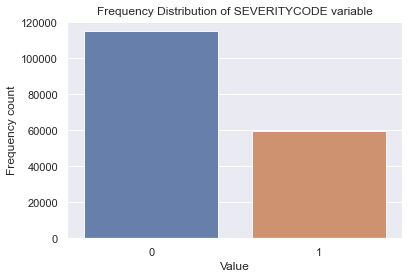

In [30]:
SEVERITYCODE_count = modeldf['SEVERITYCODE'].value_counts()
sns.set(style="darkgrid")
sns.barplot(SEVERITYCODE_count.index, SEVERITYCODE_count.values, alpha=0.9)
plt.title('Frequency Distribution of SEVERITYCODE variable')
plt.ylabel('Frequency count', fontsize=12)
plt.xlabel('Value', fontsize=12)
plt.show()

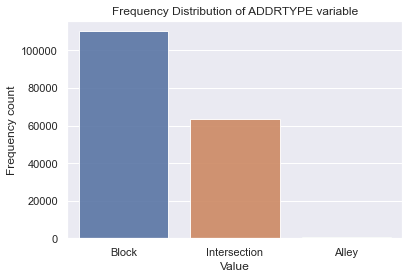

In [31]:
ADDRTYPE_count = modeldf['ADDRTYPE'].value_counts()
sns.set(style="darkgrid")
sns.barplot(ADDRTYPE_count.index, ADDRTYPE_count.values, alpha=0.9)
plt.title('Frequency Distribution of ADDRTYPE variable')
plt.ylabel('Frequency count', fontsize=12)
plt.xlabel('Value', fontsize=12)
plt.show()

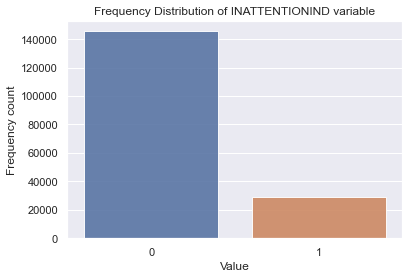

In [32]:
INATTENTIONIND_count = modeldf['INATTENTIONIND'].value_counts()
sns.set(style="darkgrid")
sns.barplot(INATTENTIONIND_count.index, INATTENTIONIND_count.values, alpha=0.9)
plt.title('Frequency Distribution of INATTENTIONIND variable')
plt.ylabel('Frequency count', fontsize=12)
plt.xlabel('Value', fontsize=12)
plt.show()

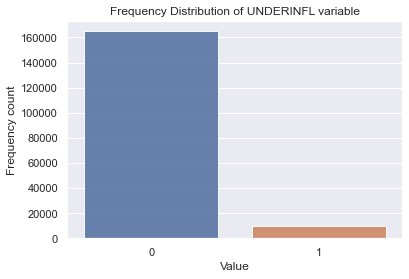

In [33]:
UNDERINFL_count = modeldf['UNDERINFL'].value_counts()
sns.set(style="darkgrid")
sns.barplot(UNDERINFL_count.index, UNDERINFL_count.values, alpha=0.9)
plt.title('Frequency Distribution of UNDERINFL variable')
plt.ylabel('Frequency count', fontsize=12)
plt.xlabel('Value', fontsize=12)
plt.show()

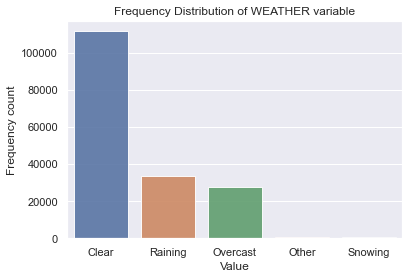

In [34]:
WEATHER_count = modeldf['WEATHER'].value_counts()
sns.set(style="darkgrid")
sns.barplot(WEATHER_count.index, WEATHER_count.values, alpha=0.9)
plt.title('Frequency Distribution of WEATHER variable')
plt.ylabel('Frequency count', fontsize=12)
plt.xlabel('Value', fontsize=12)
plt.show()

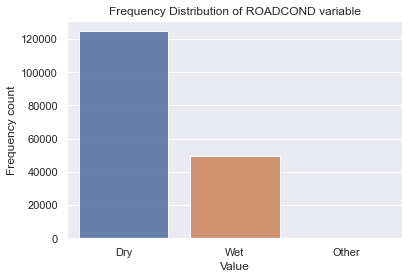

In [35]:
ROADCOND_count = modeldf['ROADCOND'].value_counts()
sns.set(style="darkgrid")
sns.barplot(ROADCOND_count.index, ROADCOND_count.values, alpha=0.9)
plt.title('Frequency Distribution of ROADCOND variable')
plt.ylabel('Frequency count', fontsize=12)
plt.xlabel('Value', fontsize=12)
plt.show()

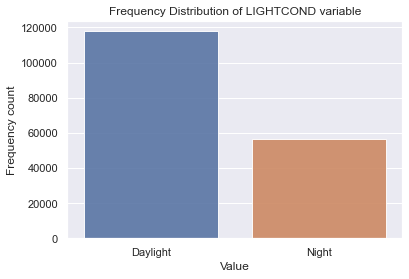

In [36]:
LIGHTCOND_count = modeldf['LIGHTCOND'].value_counts()
sns.set(style="darkgrid")
sns.barplot(LIGHTCOND_count.index, LIGHTCOND_count.values, alpha=0.9)
plt.title('Frequency Distribution of LIGHTCOND variable')
plt.ylabel('Frequency count', fontsize=12)
plt.xlabel('Value', fontsize=12)
plt.show()

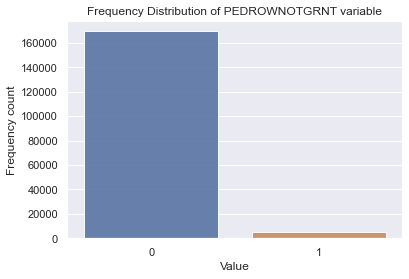

In [37]:
PEDROWNOTGRNT_count = modeldf['PEDROWNOTGRNT'].value_counts()
sns.set(style="darkgrid")
sns.barplot(PEDROWNOTGRNT_count.index, PEDROWNOTGRNT_count.values, alpha=0.9)
plt.title('Frequency Distribution of PEDROWNOTGRNT variable')
plt.ylabel('Frequency count', fontsize=12)
plt.xlabel('Value', fontsize=12)
plt.show()

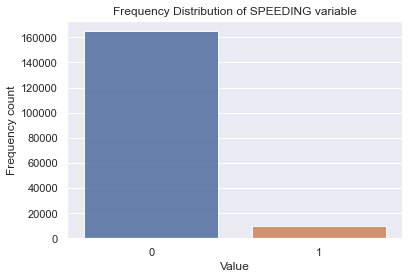

In [38]:
SPEEDING_count = modeldf['SPEEDING'].value_counts()
sns.set(style="darkgrid")
sns.barplot(SPEEDING_count.index, SPEEDING_count.values, alpha=0.9)
plt.title('Frequency Distribution of SPEEDING variable')
plt.ylabel('Frequency count', fontsize=12)
plt.xlabel('Value', fontsize=12)
plt.show()

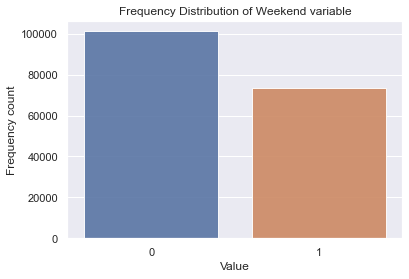

In [39]:
Weekend_count = modeldf['Weekend'].value_counts()
sns.set(style="darkgrid")
sns.barplot(Weekend_count.index, Weekend_count.values, alpha=0.9)
plt.title('Frequency Distribution of Weekend variable')
plt.ylabel('Frequency count', fontsize=12)
plt.xlabel('Value', fontsize=12)
plt.show()

### **3.1.2 Bar charts comparing frequency distribution of all Variables with Dependent Variable**

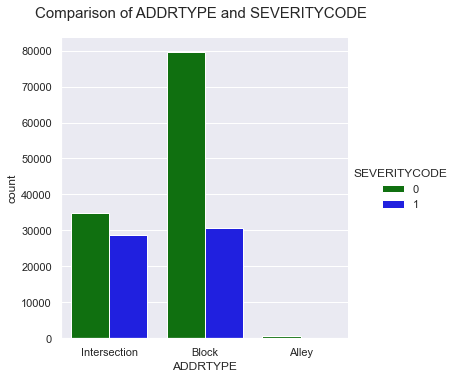

In [40]:
g = sns.catplot("ADDRTYPE", hue="SEVERITYCODE", data=modeldf, kind="count", 
            palette={1:"blue", 0:"green"})
g.fig.suptitle("Comparison of ADDRTYPE and SEVERITYCODE", x=0.45 , y=1.05, fontsize=15);

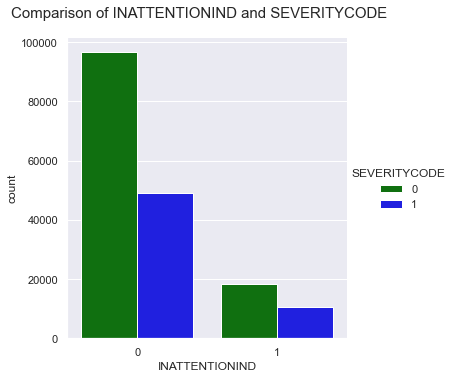

In [41]:
g = sns.catplot("INATTENTIONIND", hue="SEVERITYCODE", data=modeldf, kind="count", 
            palette={1:"blue", 0:"green"})
g.fig.suptitle("Comparison of INATTENTIONIND and SEVERITYCODE", x=0.45 , y=1.05, fontsize=15);

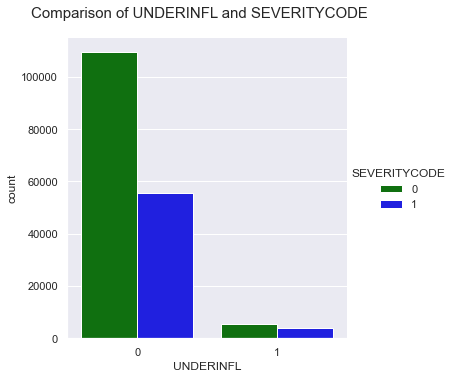

In [42]:
g = sns.catplot("UNDERINFL", hue="SEVERITYCODE", data=modeldf, kind="count", 
            palette={1:"blue", 0:"green"})
g.fig.suptitle("Comparison of UNDERINFL and SEVERITYCODE", x=0.45 , y=1.05, fontsize=15);

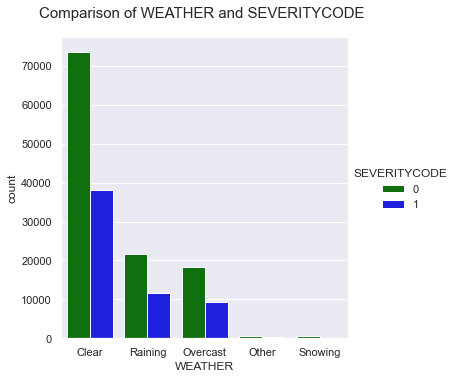

In [43]:
g = sns.catplot("WEATHER", hue="SEVERITYCODE", data=modeldf, kind="count", 
            palette={1:"blue", 0:"green"})
g.fig.suptitle("Comparison of WEATHER and SEVERITYCODE", x=0.45 , y=1.05, fontsize=15);

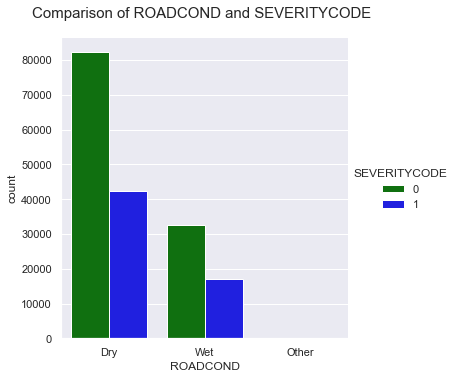

In [44]:
g = sns.catplot("ROADCOND", hue="SEVERITYCODE", data=modeldf, kind="count", 
            palette={1:"blue", 0:"green"})
g.fig.suptitle("Comparison of ROADCOND and SEVERITYCODE", x=0.45 , y=1.05, fontsize=15);

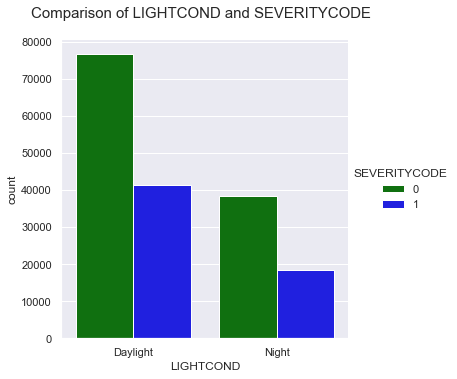

In [45]:
g = sns.catplot("LIGHTCOND", hue="SEVERITYCODE", data=modeldf, kind="count", 
            palette={1:"blue", 0:"green"})
g.fig.suptitle("Comparison of LIGHTCOND and SEVERITYCODE", x=0.45 , y=1.05, fontsize=15);

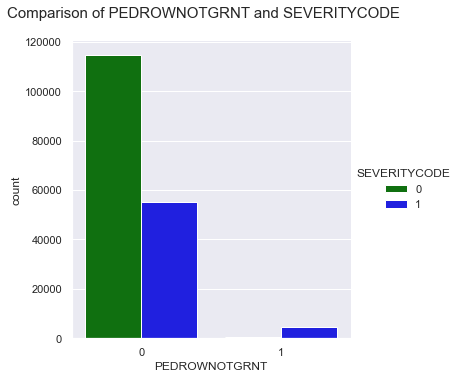

In [46]:
g = sns.catplot("PEDROWNOTGRNT", hue="SEVERITYCODE", data=modeldf, kind="count", 
            palette={1:"blue", 0:"green"})
g.fig.suptitle("Comparison of PEDROWNOTGRNT and SEVERITYCODE", x=0.45 , y=1.05, fontsize=15);

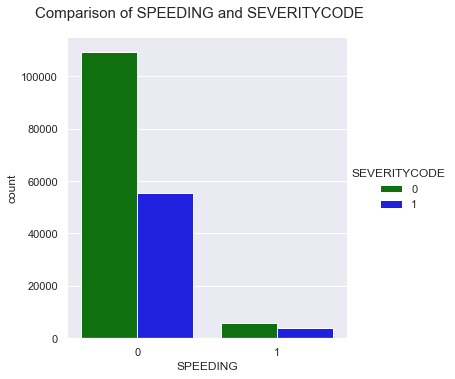

In [47]:
g = sns.catplot("SPEEDING", hue="SEVERITYCODE", data=modeldf, kind="count", 
            palette={1:"blue", 0:"green"})
g.fig.suptitle("Comparison of SPEEDING and SEVERITYCODE", x=0.45 , y=1.05, fontsize=15);

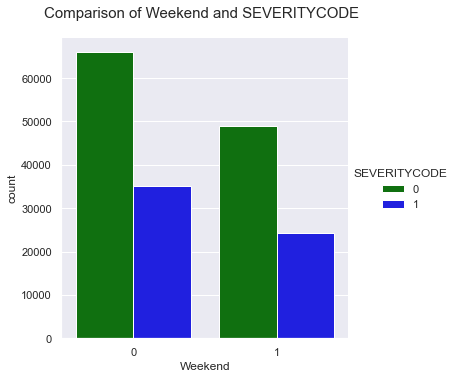

In [48]:
g = sns.catplot("Weekend", hue="SEVERITYCODE", data=modeldf, kind="count", 
            palette={1:"blue", 0:"green"})
g.fig.suptitle("Comparison of Weekend and SEVERITYCODE", x=0.45 , y=1.05, fontsize=15);

## **3.2 Create Dummy Variables**

In [49]:
# Create dummy variables for ROADCOND, WEATHER, LIGHTCOND, ADDRTYPE

In [50]:
modeldf.columns

Index(['SEVERITYCODE', 'ADDRTYPE', 'INATTENTIONIND', 'UNDERINFL', 'WEATHER',
       'ROADCOND', 'LIGHTCOND', 'PEDROWNOTGRNT', 'SPEEDING', 'Weekend'],
      dtype='object')

In [51]:
dummy_variable_1 = pd.get_dummies(modeldf["ROADCOND"])
dummy_variable_1.rename(columns={'Dry':'Road-Dry', 'Other':'Road-Other','Wet':'Road-Wet'}, inplace=True)
modeldf = pd.concat([modeldf, dummy_variable_1], axis=1)
modeldf.drop("ROADCOND", axis = 1, inplace=True)

In [52]:
dummy_variable_2 = pd.get_dummies(modeldf["WEATHER"])
dummy_variable_2.rename(columns={'Clear':'Weather-Clear', 'Raining':'Weather-Raining','Overcast':'Weather-Overcast', 'Other':'Weather-Other','Snowing':'Weather-Snowing'}, inplace=True)
modeldf = pd.concat([modeldf, dummy_variable_2], axis=1)
modeldf.drop("WEATHER", axis = 1, inplace=True)

In [53]:
dummy_variable_3 = pd.get_dummies(modeldf["LIGHTCOND"])
dummy_variable_3.rename(columns={'Daylight':'LightCond-Daylight', 'Night':'LightCond-Night'}, inplace=True)
modeldf = pd.concat([modeldf, dummy_variable_3], axis=1)
modeldf.drop("LIGHTCOND", axis = 1, inplace=True)

In [54]:
dummy_variable_4 = pd.get_dummies(modeldf["ADDRTYPE"])
dummy_variable_4.rename(columns={'Intersection':'ADDR-Intersection', 'Block':'ADDR-Block','Alley':'ADDR-Alley'}, inplace=True)
modeldf = pd.concat([modeldf, dummy_variable_4], axis=1)
modeldf.drop("ADDRTYPE", axis = 1, inplace=True)

In [55]:
modeldf.head().T

,0,1,2,3,6
SEVERITYCODE,1,1,0,0,0
INATTENTIONIND,0,0,0,0,0
UNDERINFL,0,0,0,0,0
PEDROWNOTGRNT,1,0,0,0,0
SPEEDING,0,0,0,0,0
Weekend,0,0,0,0,1
Road-Dry,1,0,1,0,1
Road-Other,0,0,0,0,0
Road-Wet,0,1,0,1,0
Weather-Clear,1,0,1,0,1


## **3.3 Pairwise Variable Comparison Matrix**

In [56]:
ham_sim = 1 - pairwise_distances(modeldf.T, metric = "hamming")
ham_sim = pd.DataFrame(ham_sim, index=modeldf.columns, columns=modeldf.columns)
ham_sim

,SEVERITYCODE,INATTENTIONIND,UNDERINFL,PEDROWNOTGRNT,SPEEDING,Weekend,Road-Dry,Road-Other,Road-Wet,Weather-Clear,Weather-Other,Weather-Overcast,Weather-Raining,Weather-Snowing,LightCond-Daylight,LightCond-Night,ADDR-Alley,ADDR-Block,ADDR-Intersection
SEVERITYCODE,1.000000,0.614771,0.650511,0.682589,0.648975,0.517724,0.430766,0.658674,0.569475,0.455684,0.657270,0.606006,0.601667,0.656117,0.456011,0.543989,0.656387,0.378425,0.624103
INATTENTIONIND,0.614771,1.000000,0.791949,0.811014,0.787133,0.546855,0.367826,0.833542,0.633034,0.416006,0.830911,0.728298,0.697785,0.830205,0.404925,0.595075,0.831896,0.446719,0.555786
UNDERINFL,0.650511,0.791949,1.000000,0.918843,0.906186,0.588317,0.306726,0.944925,0.694111,0.375244,0.941376,0.803992,0.775314,0.941359,0.294092,0.705908,0.942764,0.394504,0.608494
PEDROWNOTGRNT,0.682589,0.811014,0.918843,1.000000,0.916711,0.570615,0.296259,0.970468,0.704681,0.367310,0.966610,0.821452,0.792098,0.966753,0.335227,0.664773,0.968020,0.350217,0.653171
SPEEDING,0.648975,0.787133,0.906186,0.916711,1.000000,0.578824,0.281608,0.944099,0.718989,0.355112,0.940540,0.804966,0.791456,0.942013,0.325173,0.674827,0.941583,0.399181,0.603931
Weekend,0.517724,0.546855,0.588317,0.570615,0.578824,1.000000,0.456825,0.580119,0.543221,0.472789,0.579426,0.552811,0.556233,0.579237,0.418912,0.581088,0.579712,0.483623,0.516830
Road-Dry,0.430766,0.367826,0.306726,0.296259,0.281608,0.456825,1.000000,0.283935,0.000997,0.873427,0.286279,0.314453,0.100280,0.280358,0.646069,0.353931,0.286830,0.561811,0.436292
Road-Other,0.658674,0.833542,0.944925,0.970468,0.944099,0.580119,0.283935,1.000000,0.715068,0.360271,0.994090,0.841148,0.807242,0.994256,0.324771,0.675229,0.995603,0.368491,0.634908
Road-Wet,0.569475,0.633034,0.694111,0.704681,0.718989,0.543221,0.000997,0.715068,1.000000,0.126470,0.714615,0.686040,0.900465,0.720605,0.353645,0.646355,0.714099,0.437673,0.564293
Weather-Clear,0.455684,0.416006,0.375244,0.367310,0.355112,0.472789,0.873427,0.360271,0.126470,1.000000,0.355152,0.201809,0.168155,0.355387,0.610340,0.389660,0.361446,0.541593,0.457129


# **4. Modelling**

## **4.1 Define Features**

In [57]:
modeldf.head().T

,0,1,2,3,6
SEVERITYCODE,1,1,0,0,0
INATTENTIONIND,0,0,0,0,0
UNDERINFL,0,0,0,0,0
PEDROWNOTGRNT,1,0,0,0,0
SPEEDING,0,0,0,0,0
Weekend,0,0,0,0,1
Road-Dry,1,0,1,0,1
Road-Other,0,0,0,0,0
Road-Wet,0,1,0,1,0
Weather-Clear,1,0,1,0,1


In [58]:
modeldf.columns

Index(['SEVERITYCODE', 'INATTENTIONIND', 'UNDERINFL', 'PEDROWNOTGRNT',
       'SPEEDING', 'Weekend', 'Road-Dry', 'Road-Other', 'Road-Wet',
       'Weather-Clear', 'Weather-Other', 'Weather-Overcast', 'Weather-Raining',
       'Weather-Snowing', 'LightCond-Daylight', 'LightCond-Night',
       'ADDR-Alley', 'ADDR-Block', 'ADDR-Intersection'],
      dtype='object')

In [59]:
X = modeldf[['INATTENTIONIND', 'UNDERINFL', 'PEDROWNOTGRNT',
       'SPEEDING', 'Weekend', 'Road-Dry', 'Road-Other', 'Road-Wet',
       'Weather-Clear', 'Weather-Other', 'Weather-Overcast', 'Weather-Raining',
       'Weather-Snowing', 'LightCond-Daylight', 'LightCond-Night',
       'ADDR-Alley', 'ADDR-Block', 'ADDR-Intersection']]
y = modeldf['SEVERITYCODE'].values

## **4.2 Develop Test & Train sets**

In [60]:
# Split into Test & Train sets, (20% test)

In [61]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
TrainUniqueValues, TrainOccurCount = np.unique(y_train, return_counts=True)
print('y_train frequency counts: ',TrainUniqueValues, TrainOccurCount)
print ('Test set:', X_test.shape,  y_test.shape)
TestUniqueValues, TestOccurCount = np.unique(y_test, return_counts=True)
print('y_test frequency counts: ',TestUniqueValues, TestOccurCount)

Train set: (139561, 18) (139561,)
y_train frequency counts:  [0 1] [91822 47739]
Test set: (34891, 18) (34891,)
y_test frequency counts:  [0 1] [23127 11764]


## **4.3 Balance dataset**

3 methods:
- Oversample minority class (SEVERITYCODE = 1)
- Undersample majority class (SEVERITYCODE = 0)
- Generate synthetic sample using SMOTE

### **4.3.1 Oversample minority class**

In [62]:
oversample = RandomOverSampler(sampling_strategy='minority')
X_train_over, y_train_over = oversample.fit_resample(X_train, y_train)
# summarize class distribution
print ('Oversampled set:', X_train_over.shape,  y_train_over.shape)
OverUniqueValues, OverOccurCount = np.unique(y_train_over, return_counts=True)
print('y_train_over frequency counts: ',OverUniqueValues, OverOccurCount)

Oversampled set: (183644, 18) (183644,)
y_train_over frequency counts:  [0 1] [91822 91822]


### **4.3.2 Undersample majority class**

In [63]:
undersample = RandomUnderSampler(sampling_strategy='majority')
X_train_under, y_train_under = undersample.fit_resample(X_train, y_train)
# summarize class distribution
print ('Undersampled set:', X_train_under.shape,  y_train_under.shape)
UnderUniqueValues, UnderOccurCount = np.unique(y_train_under, return_counts=True)
print('y_train_under frequency counts: ',UnderUniqueValues, UnderOccurCount)

Undersampled set: (95478, 18) (95478,)
y_train_under frequency counts:  [0 1] [47739 47739]


### **4.3.3 Generate synthetic sample using SMOTE**

In [64]:
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())
# summarize class distribution
print('Oversampled set:', X_train_res.shape, y_train_res.shape)
ResUniqueValues, ResOccurCount = np.unique(y_train_res, return_counts=True)
print('y_train_res frequency counts: ',OverUniqueValues, OverOccurCount)

Oversampled set: (183644, 18) (183644,)
y_train_res frequency counts:  [0 1] [91822 91822]


## **4.4 Model development**

### **4.4.1 KNN**

KNN was run to provide a comparison F1 score to the other algorithms. Howver, it will not be used even if it provides the best performance, as there seems to be (based on my research) no easy way to evaluate feature importance (one of the key obejctives for this project).

In [65]:
# Identify optimal Sample Balancing Strategy by comparing F1 Scores for each of the 4 training sets 

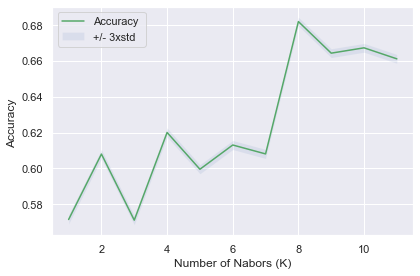

The best accuracy was with 0.6820096873119142 with k= 8
Original KNN Jaccard =  0.19496084439904665
Original KNN F1 Score =  0.6228360232501389


In [66]:
# KNN on Original (unbalanced) train set
Ks = 12
Origmean_acc = np.zeros((Ks-1))
Origstd_acc = np.zeros((Ks-1))
OrigConfustionMx = [];
for n in range(1,Ks):
    Origneigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    OrigKNNyhat=Origneigh.predict(X_test)
    Origmean_acc[n-1] = metrics.accuracy_score(y_test, OrigKNNyhat)
    Origstd_acc[n-1]=np.std(OrigKNNyhat==y_test)/np.sqrt(OrigKNNyhat.shape[0])
# Plot K
plt.plot(range(1,Ks),Origmean_acc,'g')
plt.fill_between(range(1,Ks),Origmean_acc - 1 * Origstd_acc,Origmean_acc + 1 * Origstd_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()
print( "The best accuracy was with", Origmean_acc.max(), "with k=", Origmean_acc.argmax()+1)
#Best KNN
Origneigh = KNeighborsClassifier(n_neighbors=Origmean_acc.argmax()+1).fit(X_train, y_train)
# Store metrics
OrigKNN_Jaccard = jaccard_score(y_test, OrigKNNyhat)
OrigKNN_F1 = f1_score(y_test, OrigKNNyhat, average='weighted')
# Print Metrics
print( "Original KNN Jaccard = ", OrigKNN_Jaccard)
print( "Original KNN F1 Score = ",OrigKNN_F1)

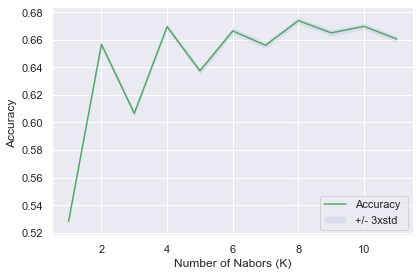

The best accuracy was with 0.6738413917629188 with k= 8
Oversampled KNN Jaccard =  0.16148892505838228
Oversampled KNN F1 Score =  0.6094287692747514


In [67]:
# KNN on OVERSAMPLED train set
Ks = 12
Overmean_acc = np.zeros((Ks-1))
Overstd_acc = np.zeros((Ks-1))
OverConfustionMx = [];
for n in range(1,Ks):
    Overneigh = KNeighborsClassifier(n_neighbors = n).fit(X_train_over,y_train_over)
    OverKNNyhat=Overneigh.predict(X_test)
    Overmean_acc[n-1] = metrics.accuracy_score(y_test, OverKNNyhat)
    Overstd_acc[n-1]=np.std(OverKNNyhat==y_test)/np.sqrt(OverKNNyhat.shape[0])
# Plot K
plt.plot(range(1,Ks),Overmean_acc,'g')
plt.fill_between(range(1,Ks),Overmean_acc - 1 * Overstd_acc,Overmean_acc + 1 * Overstd_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()
print( "The best accuracy was with", Overmean_acc.max(), "with k=", Overmean_acc.argmax()+1)
#Best KNN
Overneigh = KNeighborsClassifier(n_neighbors=Overmean_acc.argmax()+1).fit(X_train_over, y_train_over)
# Store metrics
OverKNN_Jaccard = jaccard_score(y_test, OverKNNyhat)
OverKNN_F1 = f1_score(y_test, OverKNNyhat, average='weighted')
# Print Metrics
print( "Oversampled KNN Jaccard = ", OverKNN_Jaccard)
print( "Oversampled KNN F1 Score = ",OverKNN_F1)

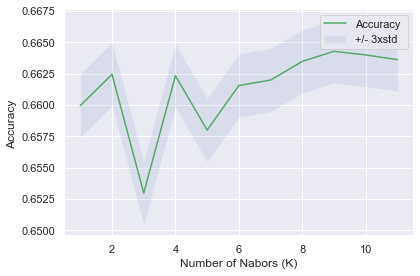

The best accuracy was with 0.6642687225932189 with k= 9
Undersampled KNN Jaccard =  0.08397721064543823
Undersampled KNN F1 Score =  0.575887648206742


In [68]:
# KNN on UNDERSAMPLED train set
Ks = 12
Undermean_acc = np.zeros((Ks-1))
Understd_acc = np.zeros((Ks-1))
UnderConfustionMx = [];
for n in range(1,Ks):
    Underneigh = KNeighborsClassifier(n_neighbors = n).fit(X_train_under,y_train_under)
    UnderKNNyhat=Underneigh.predict(X_test)
    Undermean_acc[n-1] = metrics.accuracy_score(y_test, UnderKNNyhat)
    Understd_acc[n-1]=np.std(UnderKNNyhat==y_test)/np.sqrt(UnderKNNyhat.shape[0])
# Plot K
plt.plot(range(1,Ks),Undermean_acc,'g')
plt.fill_between(range(1,Ks),Undermean_acc - 1 * Understd_acc,Undermean_acc + 1 * Understd_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()
print( "The best accuracy was with", Undermean_acc.max(), "with k=", Undermean_acc.argmax()+1)
#Best KNN
Underneigh = KNeighborsClassifier(n_neighbors=Undermean_acc.argmax()+1).fit(X_train_under, y_train_under)
# Store metrics
UnderKNN_Jaccard = jaccard_score(y_test, UnderKNNyhat)
UnderKNN_F1 = f1_score(y_test, UnderKNNyhat, average='weighted')
# Print Metrics
print( "Undersampled KNN Jaccard = ", UnderKNN_Jaccard)
print( "Undersampled KNN F1 Score = ",UnderKNN_F1)

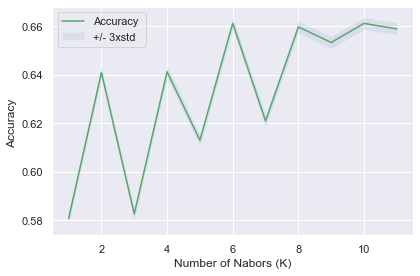

The best accuracy was with 0.6613166719211258 with k= 6
SMOTE upsampled KNN Jaccard =  0.17602659095630496
SMOTE upsampled KNN F1 Score =  0.6143892041413679


In [69]:
# KNN on SMOTE upsampled train set
Ks = 12
SMOTEmean_acc = np.zeros((Ks-1))
SMOTEstd_acc = np.zeros((Ks-1))
SMOTEConfustionMx = [];
for n in range(1,Ks):
    SMOTEneigh = KNeighborsClassifier(n_neighbors = n).fit(X_train_res,y_train_res)
    SMOTEKNNyhat=SMOTEneigh.predict(X_test)
    SMOTEmean_acc[n-1] = metrics.accuracy_score(y_test, SMOTEKNNyhat)
    SMOTEstd_acc[n-1]=np.std(SMOTEKNNyhat==y_test)/np.sqrt(SMOTEKNNyhat.shape[0])
# Plot K
plt.plot(range(1,Ks),SMOTEmean_acc,'g')
plt.fill_between(range(1,Ks),SMOTEmean_acc - 1 * SMOTEstd_acc,SMOTEmean_acc + 1 * SMOTEstd_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()
print( "The best accuracy was with", SMOTEmean_acc.max(), "with k=", SMOTEmean_acc.argmax()+1)
#Best KNN
SMOTEneigh = KNeighborsClassifier(n_neighbors=SMOTEmean_acc.argmax()+1).fit(X_train_res, y_train_res)
# Store metrics
SMOTEKNN_Jaccard = jaccard_score(y_test, SMOTEKNNyhat)
SMOTEKNN_F1 = f1_score(y_test, SMOTEKNNyhat, average='weighted')
# Print Metrics
print( "SMOTE upsampled KNN Jaccard = ", SMOTEKNN_Jaccard)
print( "SMOTE upsampled KNN F1 Score = ",SMOTEKNN_F1)

In [70]:
#Create a list of results then insert into df
list_KNNjac = [OrigKNN_Jaccard, OverKNN_Jaccard, UnderKNN_Jaccard, SMOTEKNN_Jaccard]
list_KNNf1 = [OrigKNN_F1, OverKNN_F1, UnderKNN_F1, SMOTEKNN_F1]

#Insert into df
KNNresdf = pd.DataFrame(list_KNNjac, index=['Original / Imbalanced','Oversampled','Undersampled','SMOTE'])
KNNresdf.columns = ['Jaccard Score']
KNNresdf.insert(loc=1, column='F1 Score', value=list_KNNf1)

KNNresdf.columns.name = 'Scores by Sample'
KNNresdf

Scores by Sample,Jaccard Score,F1 Score
Original / Imbalanced,0.194961,0.622836
Oversampled,0.161489,0.609429
Undersampled,0.083977,0.575888
SMOTE,0.176027,0.614389


In [71]:
# KNN with the Original (Unbalanced) training set performs best on F1 Score (0.6228)

### **4.4.2 SVM**

In [72]:
# Identify optimal Sample Balancing Strategy by comparing F1 Scores for each of the 4 training sets 

In [73]:
# SVM using RBF kernel on Original (unbalanced) train set
ORIGrbf_clf = svm.SVC(kernel='rbf')
ORIGrbf_clf.fit(X_train, y_train)
ORIGrbf_svm = ORIGrbf_clf.predict(X_test)
# Store Metrics
OrigRBFsvm_Jaccard = jaccard_score(y_test, ORIGrbf_svm)
OrigRBFsvm_F1 = f1_score(y_test, ORIGrbf_svm, average='weighted')
# Print Metrics
print( "Original SVM-rbf Jaccard = ", OrigRBFsvm_Jaccard)
print( "Original SVM-rbf F1 Score = ",OrigRBFsvm_F1)

Original SVM-rbf Jaccard =  0.09836606700775706
Original SVM-rbf F1 Score =  0.5949832794428399


In [74]:
# SVM using RBF kernel on OVERSAMPLED train set
OVERrbf_clf = svm.SVC(kernel='rbf')
OVERrbf_clf.fit(X_train_over, y_train_over)
OVERrbf_svm = OVERrbf_clf.predict(X_test)
# Store Metrics
OVERRBFsvm_Jaccard = jaccard_score(y_test, OVERrbf_svm)
OVERRBFsvm_F1 = f1_score(y_test, OVERrbf_svm, average='weighted')
# Print Metrics
print( "OVERSAMPLED SVM-rbf Jaccard = ", OVERRBFsvm_Jaccard)
print( "OVERSAMPLED SVM-rbf F1 Score = ",OVERRBFsvm_F1)

OVERSAMPLED SVM-rbf Jaccard =  0.33438380365754666
OVERSAMPLED SVM-rbf F1 Score =  0.6109552543423531


In [75]:
# SVM using RBF kernel on UNDERSAMPLED train set
UNDERrbf_clf = svm.SVC(kernel='rbf')
UNDERrbf_clf.fit(X_train_under, y_train_under)
UNDERrbf_svm = UNDERrbf_clf.predict(X_test)
# Store Metrics
UNDERRBFsvm_Jaccard = jaccard_score(y_test, UNDERrbf_svm)
UNDERRBFsvm_F1 = f1_score(y_test, UNDERrbf_svm, average='weighted')
# Print Metrics
print( "UNDERSAMPLED SVM-rbf Jaccard = ", UNDERRBFsvm_Jaccard)
print( "UNDERSAMPLED SVM-rbf F1 Score = ",UNDERRBFsvm_F1)

UNDERSAMPLED SVM-rbf Jaccard =  0.32773488418730573
UNDERSAMPLED SVM-rbf F1 Score =  0.6240158509762439


In [76]:
# SVM using RBF kernel on SMOTE upsampled train set
SMOTErbf_clf = svm.SVC(kernel='rbf')
SMOTErbf_clf.fit(X_train_res, y_train_res)
SMOTErbf_svm = SMOTErbf_clf.predict(X_test)
# Store Metrics
SMOTERBFsvm_Jaccard = jaccard_score(y_test, SMOTErbf_svm)
SMOTERBFsvm_F1 = f1_score(y_test, SMOTErbf_svm, average='weighted')
# Print Metrics
print( "SMOTE upsampled SVM-rbf Jaccard = ", SMOTERBFsvm_Jaccard)
print( "SMOTE upsampled SVM-rbf F1 Score = ",SMOTERBFsvm_F1)

SMOTE upsampled SVM-rbf Jaccard =  0.33222060957910016
SMOTE upsampled SVM-rbf F1 Score =  0.6144225518773571


In [77]:
#Create a list of results then insert into df
list_SVMjac = [OrigRBFsvm_Jaccard, OVERRBFsvm_Jaccard, UNDERRBFsvm_Jaccard, SMOTERBFsvm_Jaccard]
list_SVMf1 = [OrigRBFsvm_F1, OVERRBFsvm_F1, UNDERRBFsvm_F1, SMOTERBFsvm_F1]

#Insert into df
SVMresdf = pd.DataFrame(list_SVMjac, index=['Original / Imbalanced','Oversampled','Undersampled','SMOTE'])
SVMresdf.columns = ['Jaccard Score']
SVMresdf.insert(loc=1, column='F1 Score', value=list_SVMf1)

SVMresdf.columns.name = 'Scores by Sample'
SVMresdf

Scores by Sample,Jaccard Score,F1 Score
Original / Imbalanced,0.098366,0.594983
Oversampled,0.334384,0.610955
Undersampled,0.327735,0.624016
SMOTE,0.332221,0.614423


In [78]:
# SVM with Undersampling performs best on F1 Score (0.6229)

### **4.4.3 Decision Tree**

In [79]:
# Identify optimal Sample Balancing Strategy by comparing F1 Scores for each of the 4 training sets 

In [80]:
# Decision Tree (Scikit-learn) - all variables - ORIGINAL (unbalanced) train set
OrigTree = DecisionTreeClassifier(criterion="entropy", max_depth = 8)
OrigTree.fit(X_train,y_train)
OrigpredTree = OrigTree.predict(X_test)
# Store Metrics
OrigTree_Jaccard = jaccard_score(y_test, OrigpredTree)
OrigTree_F1 = f1_score(y_test, OrigpredTree, average='weighted')
OrigTree_Accuracy = metrics.accuracy_score(y_test, OrigpredTree)
# Print Metrics
print( "Original DecTree Jaccard = ", OrigTree_Jaccard)
print( "Original DecTree F1 Score = ",OrigTree_F1)
print("Original Decision Tree Accuracy: ", OrigTree_Accuracy)

Original DecTree Jaccard =  0.09614748677248677
Original DecTree F1 Score =  0.5937743057968439
Original Decision Tree Accuracy:  0.6866527184660801


In [81]:
# Decision Tree (Scikit-learn) - all variables - OVERSAMPLED train set
OVERTree = DecisionTreeClassifier(criterion="entropy", max_depth = 8)
OVERTree.fit(X_train_over,y_train_over)
OVERpredTree = OVERTree.predict(X_test)
# Store Metrics
OVERTree_Jaccard = jaccard_score(y_test, OVERpredTree)
OVERTree_F1 = f1_score(y_test, OVERpredTree, average='weighted')
OVERTree_Accuracy = metrics.accuracy_score(y_test, OVERpredTree)
# Print Metrics
print( "Oversampled DecTree Jaccard = ", OVERTree_Jaccard)
print( "Oversampled DecTree F1 Score = ",OVERTree_F1)
print("Oversampled Decision Tree Accuracy: ", OVERTree_Accuracy)

Oversampled DecTree Jaccard =  0.3449580598103574
Oversampled DecTree F1 Score =  0.5993312497865599
Oversampled Decision Tree Accuracy:  0.5881746008999456


In [82]:
# Decision Tree (Scikit-learn) - all variables - UNDERSAMPLED train set
UNDERTree = DecisionTreeClassifier(criterion="entropy", max_depth = 8)
UNDERTree.fit(X_train_under,y_train_under)
UNDERpredTree = UNDERTree.predict(X_test)
# Store Metrics
UNDERTree_Jaccard = jaccard_score(y_test, UNDERpredTree)
UNDERTree_F1 = f1_score(y_test, UNDERpredTree, average='weighted')
UNDERTree_Accuracy = metrics.accuracy_score(y_test, UNDERpredTree)
# Print Metrics
print( "Undersampled DecTree Jaccard = ", UNDERTree_Jaccard)
print( "Undersampled DecTree F1 Score = ",UNDERTree_F1)
print("Undersampled Decision Tree Accuracy: ", UNDERTree_Accuracy)

Undersampled DecTree Jaccard =  0.3347846889952153
Undersampled DecTree F1 Score =  0.6119509374144746
Undersampled Decision Tree Accuracy:  0.6015304806397065


In [83]:
# Decision Tree (Scikit-learn) - all variables - SMOTE train set
SMOTETree = DecisionTreeClassifier(criterion="entropy", max_depth = 8)
SMOTETree.fit(X_train_res,y_train_res)
SMOTEpredTree = SMOTETree.predict(X_test)
# Store Metrics
SMOTETree_Jaccard = jaccard_score(y_test, SMOTEpredTree)
SMOTETree_F1 = f1_score(y_test, SMOTEpredTree, average='weighted')
SMOTETree_Accuracy = metrics.accuracy_score(y_test, SMOTEpredTree)
# Print Metrics
print( "SMOTE Oversampled DecTree Jaccard = ", SMOTETree_Jaccard)
print( "SMOTE Oversampled DecTree F1 Score = ",SMOTETree_F1)
print("SMOTE Oversampled Decision Tree Accuracy: ", SMOTETree_Accuracy)

SMOTE Oversampled DecTree Jaccard =  0.33001749562609345
SMOTE Oversampled DecTree F1 Score =  0.6243900595657497
SMOTE Oversampled Decision Tree Accuracy:  0.6158608237081196


In [90]:
#Create a list of results then insert into df
list_Treejac = [OrigTree_Jaccard, OVERTree_Jaccard, UNDERTree_Jaccard, SMOTETree_Jaccard]
list_Treef1 = [OrigTree_F1, OVERTree_F1, OVERTree_F1, SMOTETree_F1]
list_Tree_Accuracy = [OrigTree_Accuracy, OVERTree_Accuracy, UNDERTree_Accuracy, SMOTETree_Accuracy]

#Insert into df
TREEresdf = pd.DataFrame(list_Treejac, index=['Original / Imbalanced','Oversampled','Undersampled','SMOTE'])
TREEresdf.columns = ['Jaccard Score']
TREEresdf.insert(loc=1, column='F1 Score', value=list_Treef1)
TREEresdf.insert(loc=2, column='Accuracy Score', value=list_Tree_Accuracy)

TREEresdf.columns.name = 'Scores by Sample'
TREEresdf

Scores by Sample,Jaccard Score,F1 Score,Accuracy Score
Original / Imbalanced,0.096147,0.593774,0.686653
Oversampled,0.344958,0.599331,0.588175
Undersampled,0.334785,0.599331,0.601530
SMOTE,0.330017,0.624390,0.615861


In [91]:
# Decision Tree with SMOTE synthetic upsampling performs best on F1 Score (0.624390)

### **4.4.4 Logistic regression**

In [92]:
# Identify optimal Sample Balancing Strategy by comparing F1 Scores for each of the 4 training sets 

In [93]:
#Logistic regression (Scikit-learn) - all variables - ORIGINAL (unbalanced) train set
LR = LogisticRegression(C=0.01, solver='lbfgs').fit(X_train,y_train)
yhat = LR.predict(X_test)
yhat_prob = LR.predict_proba(X_test)
# Store metrics
OrigLR_Jaccard = jaccard_score(y_test, yhat)
OrigLR_F1 = f1_score(y_test, yhat, average='weighted')
OrigLR_LogLoss = log_loss (y_test, yhat_prob)
# Print Metrics
print( "Original LR Jaccard = ", OrigLR_Jaccard)
print( "Original LR F1 Score = ", OrigLR_F1)
print( "Original LR LogLoss = ", OrigLR_LogLoss)

Original LR Jaccard =  0.10289178340296551
Original LR F1 Score =  0.5968599473389387
Original LR LogLoss =  0.6035826133276433


In [94]:
# Logistic regression (Scikit-learn) - all variables - OVERSAMPLED train set
OVERLR = LogisticRegression(C=0.01, solver='lbfgs').fit(X_train_over,y_train_over)
OVERyhat = OVERLR.predict(X_test)
OVERyhat_prob = OVERLR.predict_proba(X_test)
# Store metrics
OVERLR_Jaccard = jaccard_score(y_test, OVERyhat)
OVERLR_F1 = f1_score(y_test, OVERyhat, average='weighted')
OVERLR_LogLoss = log_loss (y_test, OVERyhat_prob)
# Print Metrics
print( "OverSampled LR Jaccard = ", OVERLR_Jaccard)
print( "OverSampled LR F1 Score = ", OVERLR_F1)
print( "OverSampled LR LogLoss = ", OVERLR_LogLoss)

OverSampled LR Jaccard =  0.3269802853829476
OverSampled LR F1 Score =  0.6254365581279845
OverSampled LR LogLoss =  0.653891911670521


In [95]:
# Logistic regression (Scikit-learn) - all variables - UNDERSAMPLED train set
UNDERLR = LogisticRegression(C=0.01, solver='lbfgs').fit(X_train_under,y_train_under)
UNDERyhat = UNDERLR.predict(X_test)
UNDERyhat_prob = UNDERLR.predict_proba(X_test)
# Store metrics
UNDERLR_Jaccard = jaccard_score(y_test, UNDERyhat)
UNDERLR_F1 = f1_score(y_test, UNDERyhat, average='weighted')
UNDERLR_LogLoss = log_loss (y_test, UNDERyhat_prob)
# Print Metrics
print( "UnderSampled LR Jaccard = ", UNDERLR_Jaccard)
print( "UnderSampled LR F1 Score = ", UNDERLR_F1)
print( "UnderSampled LR LogLoss = ", UNDERLR_LogLoss)

UnderSampled LR Jaccard =  0.32591237165802583
UnderSampled LR F1 Score =  0.6274126098799897
UnderSampled LR LogLoss =  0.65448523251628


In [96]:
# Logistic regression (Scikit-learn) - all variables - SMOTE train set
SMOTELR = LogisticRegression(C=0.01, solver='lbfgs').fit(X_train_res, y_train_res)
SMOTEyhat = SMOTELR.predict(X_test)
SMOTEyhat_prob = SMOTELR.predict_proba(X_test)
# Store metrics
SMOTELR_Jaccard = jaccard_score(y_test, SMOTEyhat)
SMOTELR_F1 = f1_score(y_test, SMOTEyhat, average='weighted')
SMOTELR_LogLoss = log_loss (y_test, SMOTEyhat_prob)
# Print Metrics
print( "SMOTE LR Jaccard = ", SMOTELR_Jaccard)
print( "SMOTE LR F1 Score = ", SMOTELR_F1)
print( "SMOTE LR LogLoss = ", SMOTELR_LogLoss)

SMOTE LR Jaccard =  0.32538590860461564
SMOTE LR F1 Score =  0.6278352570535545
SMOTE LR LogLoss =  0.6540208343696389


In [99]:
#Create a list of results then insert into df
list_LRjac = [OrigLR_Jaccard, OVERLR_Jaccard, UNDERLR_Jaccard, SMOTELR_Jaccard]
list_LRf1 = [OrigLR_F1, OVERLR_F1, UNDERLR_F1, SMOTELR_F1]
list_LRlogloss = [OrigLR_LogLoss, OVERLR_LogLoss, UNDERLR_LogLoss, SMOTELR_LogLoss]

#Insert into df
LRresdf = pd.DataFrame(list_LRjac, index=['Original / Imbalanced','Oversampled','Undersampled','SMOTE'])
LRresdf.columns = ['Jaccard Score']
LRresdf.insert(loc=1, column='F1 Score', value=list_LRf1)
LRresdf.insert(loc=2, column='LogLoss Score', value=list_LRlogloss)

LRresdf.columns.name = 'Scores by Sample'
LRresdf

Scores by Sample,Jaccard Score,F1 Score,LogLoss Score
Original / Imbalanced,0.102892,0.596860,0.603583
Oversampled,0.326980,0.625437,0.653892
Undersampled,0.325912,0.627413,0.654485
SMOTE,0.325386,0.627835,0.654021


In [100]:
# Logistic regression with SMOTE synthetic upsampling performs best on F1 Score (0.627835)

# **5 Results**

In [101]:
#Create a list of results then insert into df
list_Imbalanced = [OrigKNN_F1, OrigRBFsvm_F1, OrigTree_F1, OrigLR_F1]
list_Oversampled = [OverKNN_F1, OVERRBFsvm_F1, OVERTree_F1, OVERLR_F1]
list_Undersampled = [UnderKNN_F1, UNDERRBFsvm_F1, UNDERTree_F1, UNDERLR_F1]
list_SMOTE = [SMOTEKNN_F1, SMOTERBFsvm_F1, SMOTETree_F1, SMOTELR_F1]

#Insert into df
resultsdf = pd.DataFrame(list_Imbalanced, index=['KNN','SVM','Decision Tree','LogisticRegression'])
resultsdf.columns = ['Original Imbalanced']
resultsdf.insert(loc=1, column='Oversampled', value=list_Oversampled)
resultsdf.insert(loc=2, column='Undersampled', value=list_Undersampled)
resultsdf.insert(loc=3, column='SMOTE upsampled', value=list_SMOTE)

resultsdf.columns.name = 'F1 Scores by Sample & Algorithm'
resultsdf

F1 Scores by Sample & Algorithm,Original Imbalanced,Oversampled,Undersampled,SMOTE upsampled
KNN,0.622836,0.609429,0.575888,0.614389
SVM,0.594983,0.610955,0.624016,0.614423
Decision Tree,0.593774,0.599331,0.611951,0.624390
LogisticRegression,0.596860,0.625437,0.627413,0.627835


In [106]:
print (classification_report(y_test, SMOTEyhat))

              precision    recall  f1-score   support

           0       0.74      0.66      0.70     23127
           1       0.45      0.54      0.49     11764

    accuracy                           0.62     34891
   macro avg       0.59      0.60      0.59     34891
weighted avg       0.64      0.62      0.63     34891



[[ 6387  5377]
 [ 7865 15262]]
Confusion matrix, without normalization
[[ 6387  5377]
 [ 7865 15262]]


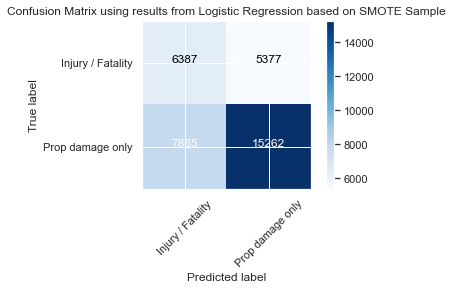

In [107]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix using results from Logistic Regression based on SMOTE Sample',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
print(confusion_matrix(y_test, SMOTEyhat, labels=[1,0]))
 
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, SMOTEyhat, labels=[1,0])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Injury / Fatality','Prop damage only'],normalize= False,  title='Confusion Matrix using results from Logistic Regression based on SMOTE Sample')


In [110]:
# print coefficients for SMOTE LogReg
coef = SMOTELR.coef_[0]
#Insert into df
coef_df = pd.DataFrame(coef, index=['INATTENTIONIND', 'UNDERINFL', 'PEDROWNOTGRNT',
       'SPEEDING', 'Weekend', 'Road-Dry', 'Road-Other', 'Road-Wet',
       'Weather-Clear', 'Weather-Other', 'Weather-Overcast', 'Weather-Raining',
       'Weather-Snowing', 'LightCond-Daylight', 'LightCond-Night',
       'ADDR-Alley', 'ADDR-Block', 'ADDR-Intersection'])
coef_df.columns = ['Coefficients']
coef_df.columns.name = 'Logistic Regression Coefficients'
coef_df

Logistic Regression Coefficients,Coefficients
INATTENTIONIND,0.302761
UNDERINFL,0.528675
PEDROWNOTGRNT,2.313794
SPEEDING,0.475095
Weekend,-0.046417
Road-Dry,-0.034198
Road-Other,0.026697
Road-Wet,-0.077155
Weather-Clear,0.071903
Weather-Other,0.061080
